In [6]:
# embed_documents.py
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
import pickle
import numpy as np

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)

# data cleaning before spliting
# def clean_text(text):
#     return " ".join(text.strip().split())


# Load and split documents
all_texts = []
for filename in os.listdir("documents"):
    with open(os.path.join("documents", filename), "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
        chunks = splitter.split_text(text)
        all_texts.extend(chunks)

# Generate embeddings
embeddings = model.encode(all_texts, normalize_embeddings=True)
# Generate embeddings with batching

# embeddings = model.encode(all_texts, normalize_embeddings=True, batch_size=32, show_progress_bar=True)
# embeddings = np.array(embeddings, dtype=np.float32)


# Save as pickle for use in FAISS
with open("faiss_data.pkl", "wb") as f:
    pickle.dump({
        "texts": all_texts,
        "embeddings": np.array(embeddings)
    }, f)

print("✅ FAISS-compatible data saved.")


/home/eyasu/miniconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ FAISS-compatible data saved.


WARNING clustering 159 points to 5 centroids: please provide at least 195 training points


Number of clusters (nlist): 5
Number of vectors in index: 159


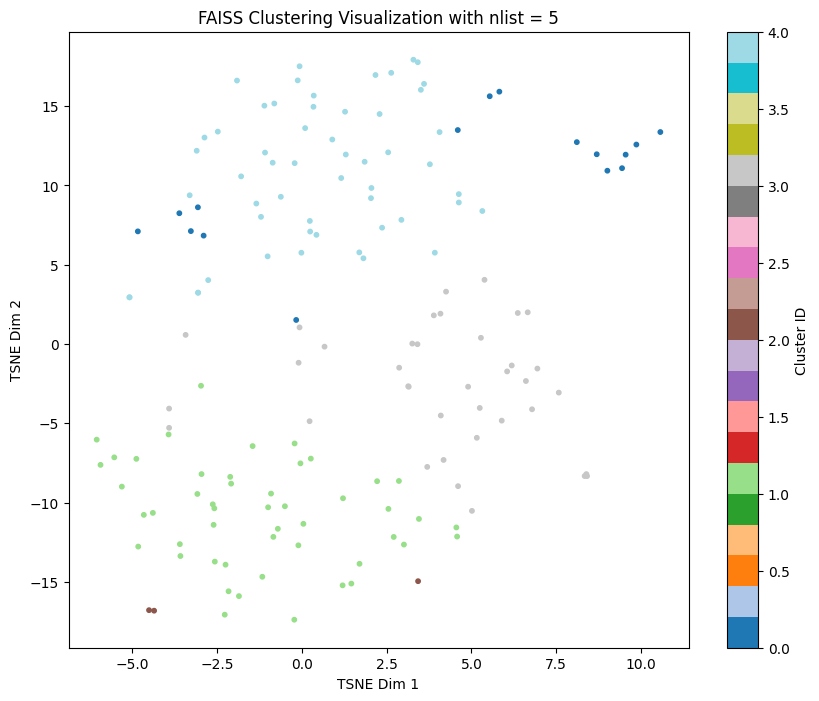

In [7]:
import faiss
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load embeddings
with open("faiss_data.pkl", "rb") as f:
    data = pickle.load(f)
embeddings = data["embeddings"]

# Step 1: Reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(embeddings)

# Step 2: Cluster with FAISS
dimension = embeddings.shape[1]
nlist = 5
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
index.train(embeddings)
index.add(embeddings)

# Assign each vector to its closest centroid
_, cluster_ids = index.quantizer.search(embeddings, 1)
cluster_ids = cluster_ids.flatten()

# Step 3: Plot
print("Number of clusters (nlist):", index.nlist)
print("Number of vectors in index:", index.ntotal)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_ids, cmap='tab20', s=10)
plt.title(f"FAISS Clustering Visualization with nlist = {nlist}")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(scatter, label='Cluster ID')
plt.show()
